In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

from PIL import Image

def im2gnp(image):
    """Converts a PIL image into an image stored as a 2-D Numpy array in grayscale."""
    return np.array(image.convert ('L'))

def gnp2im(image_np):
    """Converts an image stored as a 2-D grayscale Numpy array into a PIL image."""
    return Image.fromarray(image_np.astype(np.uint8), mode='L')

def imshow_gray(im, ax=None):
    if ax is None:
        f = plt.figure()
        ax = plt.axes()
    ax.imshow(im,
              interpolation='nearest',
              cmap=plt.get_cmap('gray'))

Matplotlib is building the font cache; this may take a moment.


In [2]:
import requests
import os
import hashlib
import io

def on_vocareum():
    return os.path.exists('.voc')

def download(file, local_dir="", url_base=None, checksum=None):
    local_file = "{}{}".format(local_dir, file)
    print (local_file)
    if not os.path.exists(local_file):
        if url_base is None:
            url_base = "https://cse6040.gatech.edu/datasets/"
        url = "{}{}".format(url_base, file)
        print("Downloading: {} ...".format(url))
        r = requests.get(url)
        with open(local_file, 'wb') as f:
            f.write(r.content)
            
    if checksum is not None:
        with io.open(local_file, 'rb') as f:
            body = f.read()
            body_checksum = hashlib.md5(body).hexdigest()
            assert body_checksum == checksum, \
                "Downloaded file '{}' has incorrect checksum: '{}' instead of '{}'".format(local_file,
                                                                                           body_checksum,
                                                                                           checksum)
    print("'{}' is ready!".format(file))
    
URL_BASE = "https://cse6040.gatech.edu/datasets/tech-tower/"
DATA_PATH = "./resource/asnlib/publicdata/" if on_vocareum() else ""
datasets = {'tt1.jpg': '380479dfdab7cdc100f978b0e00ad814'}

for filename, checksum in datasets.items():
    download(filename, local_dir=DATA_PATH, url_base=URL_BASE, checksum=checksum)
    
print("\n(All data appears to be ready.)")

./resource/asnlib/publicdata/tt1.jpg
'tt1.jpg' is ready!

(All data appears to be ready.)


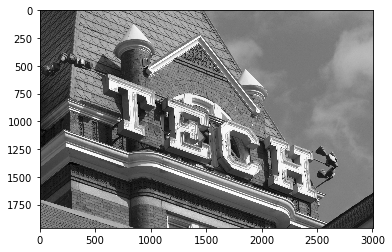

In [3]:
pic_raw = Image.open('{}tt1.jpg'.format(DATA_PATH), 'r')
pic = im2gnp(pic_raw)
imshow_gray(pic)

In [14]:
def sizeof_image(I):
    assert type(I) is np.ndarray
    assert len(I.shape) == 2
    return I.shape[0] * I.shape[1]


In [16]:
def compress_image(I, k):
    U, S, VT = np.linalg.svd(I, full_matrices=False)
    
    Uk = U[:, :k]
    Sk = S[:k]
    VkT = VT[:k, :]

    return S, Uk, VkT

# Runs your function:
k = 10
Sigma, Uk, VkT = compress_image(pic, k)

print(Sigma.shape)
print(Uk.shape)
print(VkT.shape)

(1960,)
(1960, 10)
(10, 3008)


In [24]:
def sizeof_compressed_image(Sigma, Uk, VkT):
    m, k_U = Uk.shape
    k_V, n = VkT.shape
    k = len(Sigma[:k_U])

    size_Uk = m * k_U
    size_VkT = k_V * n
    size_Sigma = k

    total_size_bytes = (size_Uk + size_VkT) * 8 + size_Sigma * 8
    equivalent_pixels = total_size_bytes

    return equivalent_pixels


In [26]:
def compression_error (Sigma, k):
    """
    Given the singular values of a matrix, return the
    relative reconstruction error.
    """
    frobenius_norm_original = np.sqrt(np.sum(Sigma ** 2))
    
    frobenius_norm_error = np.sqrt(np.sum(Sigma[k:] ** 2))
    
    relative_error = frobenius_norm_error / frobenius_norm_original
    
    return relative_error


In [44]:
def uncompress_image(Sigma, Uk, VkT):
    assert Uk.shape[1] == VkT.shape[0]
    
    Sigma_k = np.diag(Sigma[:Uk.shape[1]])
    reconstructed_image = Uk @ Sigma_k @ VkT

    return reconstructed_image


In [46]:
def find_rank(rel_err_target, Sigma):
    squared_singular_values = Sigma ** 2
    total_frobenius_norm_squared = np.sum(squared_singular_values)
    cumulative_sum = np.cumsum(squared_singular_values)
    remaining_error = total_frobenius_norm_squared - cumulative_sum
    relative_error = np.sqrt(remaining_error / total_frobenius_norm_squared)
    k = np.argmax(relative_error <= rel_err_target) + 1
    return k
    
rel_err_target = 0.15
k_target = find_rank(rel_err_target, Sigma)

print("Relative error target:", rel_err_target)
print("Suggested value of k:", k_target)

Relative error target: 0.15
Suggested value of k: 47
